In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from itertools import combinations
from scipy.optimize import minimize, rosen, rosen_der
from matplotlib.patches import Patch

import cvxopt as opt
from cvxopt import blas, solvers

In [2]:
def calcular_risco(seeds,retornos,horizonte_dias):
    """
calcular_risco()

Essa função calcula o risco de uma carteira de investimentos a partir de um conjunto de retornos de ativos e um horizonte de dias desejado.

Parâmetros:
seeds (int): Número de combinações de pesos para a carteira
retornos (DataFrame): Um dataframe contendo os retornos dos ativos
horizonte_dias (int): Número de dias a serem considerados

Retorno:
Um dataframe contendo os pesos, retorno, risco e a relação risco-retorno para cada combinação de pesos gerada.
"""
    resultado = {'pesos':[],'retorno':[],'risco':[],'ratio':[]}
    for n in range(seeds):
        k = np.random.rand(len(retornos.columns))
        w = k / np.sum(k)
        retorno_medio = retornos.mean() * horizonte_dias
        retorno_carteira = np.dot(retorno_medio, w)
  

        cov_matrix = retornos.cov()
        risco_carteira = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w))) * np.sqrt(horizonte_dias)
        ratio = retorno_carteira/risco_carteira #relação risco retorno, ou shape ratio de Markowitz

        resultado['pesos'].append(w)
        resultado['retorno'].append(retorno_carteira)
        resultado['risco'].append(risco_carteira)
        resultado['ratio'].append(ratio)

    return pd.DataFrame(resultado)

In [3]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(margem.mean() * weights) * 12
    vol = np.sqrt(np.dot(weights.T, np.dot(margem.cov()*12, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

#def neg_sharpe(weights):
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
#    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1
    
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [91]:
geração = pd.read_excel('Geração por fonte.xlsx')
fator_capacidade = geração.drop(['Geração MRE','Garantia física MRE'],axis=1)
fator_capacidade.dropna(inplace=True)

In [92]:
fator_capacidade.describe()

,GSF,FC Eolica,FC Solar
count,83.000000,83.000000,83.00000
mean,0.843468,0.422156,0.22132
std,0.229729,0.106719,0.03961
min,0.483267,0.204410,0.04510
25%,0.669674,0.341061,0.20905
50%,0.821561,0.413628,0.22710
75%,0.974783,0.507514,0.24125
max,1.625176,0.602448,0.29730


In [93]:
fator_capacidade['ano'] = fator_capacidade['Data'].dt.year
fator_capacidade['mes'] = fator_capacidade['Data'].dt.month

In [94]:
fator_capacidade['Eolica'] = fator_capacidade["FC Eolica"]/ np.percentile(fator_capacidade["FC Eolica"],50)
fator_capacidade['Solar'] = fator_capacidade["FC Solar"]/ np.percentile(fator_capacidade["FC Solar"],50)
fator_capacidade['Hídrica'] = fator_capacidade["GSF"]/ np.percentile(fator_capacidade["GSF"],50)

In [118]:
#condições para tempo umido e seco
condições = [(fator_capacidade['mes'].isin([5,6,7,8,9,10,11])), 
             (fator_capacidade['mes'].isin([12,1,2,3,4]))]

opções = ['seco','úmido']

fator_capacidade['Periodo'] = np.select(condições, opções)
fator_capacidade['base'] = 1
fator_capacidade['úmido'] = np.select(condições, [0,fator_capacidade['Hídrica']])
fator_capacidade['seco'] = np.select(condições, [fator_capacidade['Hídrica'],0])

fator_capacidade['Data'] = pd.to_datetime(fator_capacidade['Data']).dt.strftime('%Y-%m')

#fechar trimestres
condições = [(fator_capacidade['mes'].isin([3,6,9,12])), 
             (fator_capacidade['mes'].isin([1,2,4,5,7,8,10,11,3,9]))]

opções = [fator_capacidade['Data'],'']

fator_capacidade['Trimestres'] = np.select(condições, opções)

fator_capacidade.reset_index(drop=True,inplace=True)


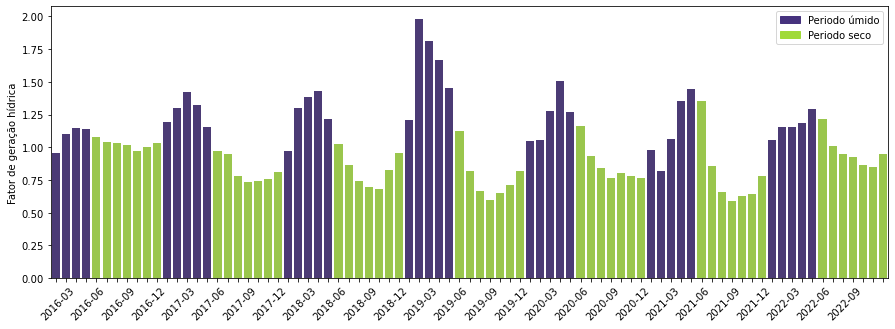

In [122]:
fig, ax = plt.subplots(figsize=(15,5))
colores = sns.color_palette("viridis")

sns.barplot(data=fator_capacidade, y='úmido', x='Data',color=colores[0], ax=ax)
sns.barplot(data=fator_capacidade, y='seco', x='Data',color=colores[5], ax=ax)
ax.set_xticklabels(labels=fator_capacidade['Trimestres'], rotation=45, ha='right')

ax.set_ylabel('Fator de geração hídrica')
ax.set_xlabel('')

# Cria os objetos Patch para as cores
patches = [Patch(color=colores[0], label='Periodo úmido'),Patch(color=colores[5], label='Periodo seco')]


# Adiciona a legenda com os objetos Patch
ax.legend(handles=patches)


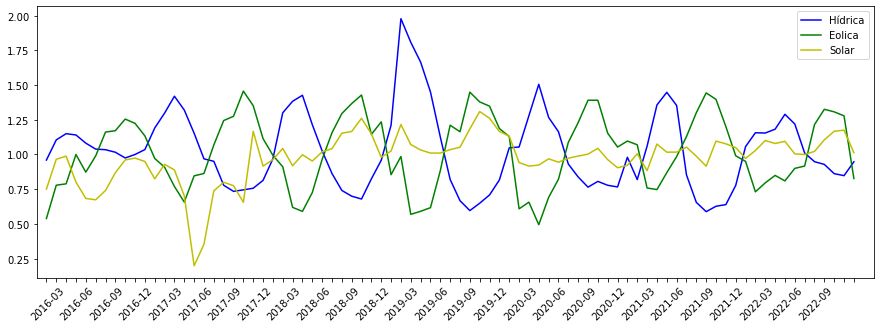

,Eolica,Solar,Hídrica
count,83.000000,83.000000,83.000000
mean,1.020617,0.974551,1.026665
std,0.258006,0.174418,0.279625
min,0.494189,0.198591,0.588230
25%,0.824560,0.920520,0.815124
50%,1.000000,1.000000,1.000000
75%,1.226981,1.062307,1.186502
max,1.456496,1.309115,1.978156


In [178]:
plt.figure(figsize=(15,5))

# Usa a coluna 'idx' como eixo x
fig = sns.lineplot(data=fator_capacidade[['Hídrica','Eolica','Solar']], palette=('b','g','y'), dashes=False)

# Define os rótulos do eixo x como as datas
plt.xticks(range(len(fator_capacidade)), fator_capacidade['Trimestres'],rotation=45, ha='right')

fig.set_xlim(-1,len(fator_capacidade)+1)

plt.show()

fator_capacidade[['Eolica','Solar','Hídrica']].describe()

In [183]:
preços = pd.read_excel("PLD.xlsx")
preços = preços[preços['Data'].dt.year >= 2016]
preços['mes'] = preços['Data'].dt.month
preços['Data'] = pd.to_datetime(preços['Data']).dt.strftime('%Y-%m')


In [184]:

#fechar trimestres
condições = [(preços['mes'].isin([3,6,9,12])), 
             (preços['mes'].isin([1,2,4,5,7,8,10,11,3,9]))]

opções = [preços['Data'],'']

preços['Trimestres'] = np.select(condições, opções)
preços.reset_index(drop=True,inplace=True)

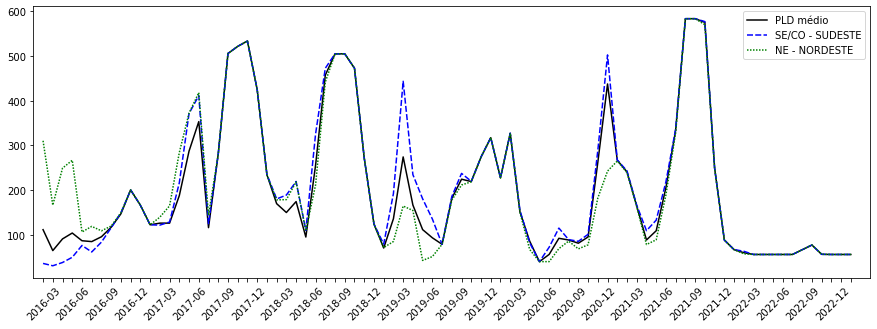

In [222]:
fig, ax = plt.subplots(figsize=(15,5))

# Usa a coluna 'idx' como eixo x
sns.lineplot(ax=ax,data=preços[['Total','SE/CO - SUDESTE','NE - NORDESTE']],palette=['black','b','g'], dashes=True)

# Define os rótulos do eixo x como as datas
plt.xticks(range(len(preços)), preços['Trimestres'],rotation=45, ha='right')

# Cria os objetos Patch para as cores
patches = [Patch(color='b', label='Sudeste'),Patch(color='g', label='Nordeste'),Patch(color='black', label='PLD médio')]

# Adiciona a legenda com os objetos Patch
ax.legend(labels=['PLD médio','SE/CO - SUDESTE','NE - NORDESTE'])

ax.set_xlim(-1,len(preços)+1)

plt.show()

In [223]:
df_exposição = pd.merge(fator_capacidade[['Data','Hídrica','Solar','Eolica','mes','ano']],
                    preços[['Data','NE - NORDESTE','SE/CO - SUDESTE','Total']])

In [224]:
#exposição por cada MWm contratado, assumindo que todos os meses tenha 30 dias

df_exposição['exp hidrica'] = (df_exposição['Hídrica']-1) * df_exposição['SE/CO - SUDESTE'] * 24 * 30
df_exposição['exp eolica'] = (df_exposição['Eolica']-1 )* df_exposição['NE - NORDESTE'] * 24 * 30
df_exposição['exp solar'] = (df_exposição['Solar']-1) *  df_exposição['Total'] * 24 * 30

In [225]:
df_exposição.head(5).round(2)

,Data,Hídrica,Solar,Eolica,mes,ano,NE - NORDESTE,SE/CO - SUDESTE,Total,exp hidrica,exp eolica,exp solar
0,2016-01,0.96,0.75,0.54,1,2016,310.38,35.66,111.28,-1029.20,-103075.71,-19969.56
1,2016-02,1.11,0.97,0.78,2,2016,166.28,30.42,64.39,2300.92,-26486.85,-1592.19
2,2016-03,1.15,0.99,0.79,3,2016,249.11,37.73,90.58,4069.81,-37908.41,-775.33
3,2016-04,1.14,0.80,1.00,4,2016,266.71,49.42,103.75,5001.86,0.00,-14867.99
4,2016-05,1.08,0.68,0.87,5,2016,106.07,75.93,86.47,4462.78,-9706.05,-19711.62


In [226]:
ROL = (200 * 24 * 30) * np.array([0.8985,0.9635,0.9635])
exposição = df_exposição[['exp hidrica','exp eolica','exp solar']] * np.array([0.9075,1,1])

margem = ROL - exposição
margem.columns = ['margem hidrica','margem eolica','margem solar']

,margem hidrica,margem eolica,margem solar
0,130317.996591,241819.712664,158713.556671
1,127295.914495,165230.854019,140336.189168
2,125690.651759,176652.413238,139519.331572
3,124844.815748,138744.000000,153611.993659
4,125334.023097,148450.050947,158455.617701


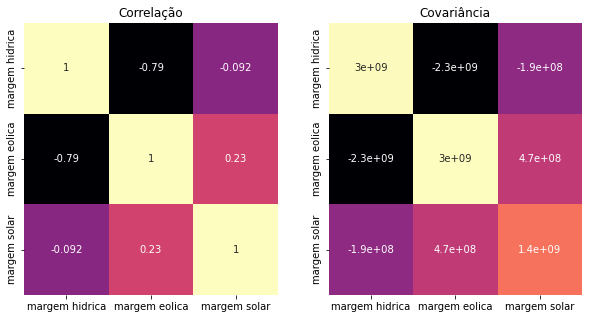

In [227]:
f, axes = plt.subplots(1, 2, figsize = (10,5))

sns.heatmap(margem.corr(),cbar=False,annot=True,cmap="magma",ax=axes[0]).set_title('Correlação')
sns.heatmap(margem.cov(),cbar=False,annot=True,cmap="magma",ax=axes[1]).set_title('Covariância')

margem.head(5)

In [248]:
seeds = 10000
horizonte_meses = 12
resultado = calcular_risco(seeds,margem,horizonte_meses)

In [249]:
best_ratio = resultado.sort_values('ratio',ignore_index=True,ascending=False).head(1)

best_ratio_w = pd.DataFrame([['hídrica','eolica','solar'],list(best_ratio['pesos'][0].round(2))],
                            columns=['hídrica','eolica','solar']).drop(0)


init_guess = [.33,.33,.34]
bounds = ((0,1),(0,1),(0,1))

frontier_y = np.linspace(resultado['retorno'].min(),resultado['retorno'].max(),200)
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda wt: get_ret_vol_sr(wt)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])
    


In [250]:
frontier = pd.DataFrame({'x':frontier_x,'y':frontier_y})
frontier = frontier[frontier['y'] >= best_ratio['retorno'][0]]

C:\Users\caiozas\AppData\Local\Temp\ipykernel_23680\2094030521.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)
C:\Users\caiozas\AppData\Local\Temp\ipykernel_23680\2094030521.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


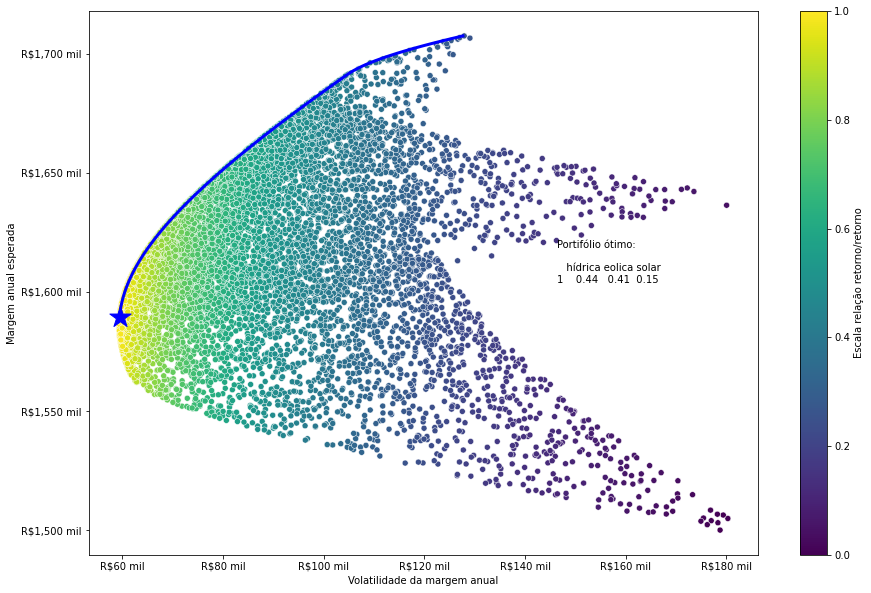

In [252]:
plt.figure(figsize=(15,10))
g = sns.scatterplot(data=resultado,x='risco',y='retorno',palette='viridis',hue='ratio',legend=False)
plt.plot(frontier['x'],frontier['y'], 'b', linewidth=3)
plt.scatter(best_ratio['risco'], best_ratio['retorno'],color='b',s=500,marker="*")

plt.colorbar(label='Escala relação retorno/retorno')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Volatilidade da margem anual')
plt.ylabel('Margem anual esperada')
#plt.title('Otimização de Portifólio')
plt.annotate(f'Portifólio ótimo:\n\n {best_ratio_w}', xy=(0.7, 0.5), xycoords='axes fraction')

xlabels = ['R${:,.0f} mil'.format(x) for x in g.get_xticks()/10**3]
ylabels = ['R${:,.0f} mil'.format(x) for x in g.get_yticks()/10**3]
g.set_xticklabels(xlabels)
g.set_yticklabels(ylabels)
print()

,P,Margem,Desvio
0,1,R$62 mil,-52%
1,5,R$88 mil,-33%
2,25,R$117 mil,-11%
3,50,R$131 mil,0%
4,75,R$145 mil,11%
5,95,R$178 mil,36%
6,99,R$203 mil,55%


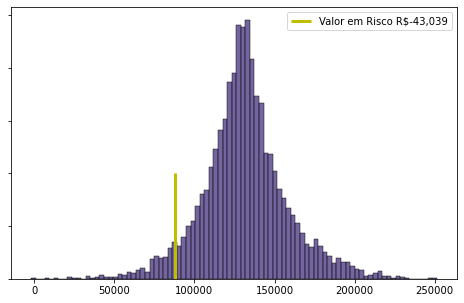

In [183]:
#parametros___________________________________________________________________________

seeds = 10000
horizonte_meses = 12
w = resultado['pesos'][resultado[resultado['ratio'] == resultado['ratio'].max()].index[0]]
w_asis = [.75,.2,.05]



#simulador___________________________________________________________________________

df_exposição2 = df_exposição[['Hídrica','Eolica','Solar','SE/CO - SUDESTE','NE - NORDESTE']]

min_vals = np.array(df_exposição2.min())-.1
max_vals = np.array(df_exposição2.max())+.1

dist_norm = np.random.multivariate_normal(df_exposição2.mean(),df_exposição2.cov(),seeds)


mask = np.all((dist_norm >= min_vals) & (dist_norm <= max_vals), axis=1)
dist_norm = dist_norm[mask].T


#exposição por cada MWm contratado, assumindo que todos os meses tenha 30 dias

sim_expo = np.array([(dist_norm[0]-1) * (dist_norm[3]* 24 * 30), #hídrica
                     (dist_norm[1]-1 )* (dist_norm[4] * 24 * 30), #eólica
                     (dist_norm[2]-1) *  (dist_norm[3] * 24 * 30) #solar
                    ]).T * np.array([0.8985,1,1]) #PIS e COFINS

sim_ROL = (200 * 24 * 30) * np.array([0.8985,0.9635,0.9635])

sim_margem = np.dot(sim_ROL - sim_expo,w_asis)

    
plt.figure(figsize=(8,5))

media = np.mean(sim_margem)
P5 = np.percentile(sim_margem,5)
P95 = np.percentile(sim_margem,95)
P50 = np.percentile(sim_margem,50)
plt.vlines(x=P5,ymin=0,ymax=200,
           colors = 'y',linewidth=3,
           label='Valor em Risco R${:,.0f}'.format(P5-P50))
#plt.vlines(x=P95,ymin=0,ymax=200,colors = 'red',label='V@R P95 R${:,.0f}'.format(P95-P50))
ax = sns.histplot(sim_margem,color=sns.color_palette("viridis")[0])
ax.set_yticklabels('')
ax.set(ylabel='')
plt.legend()

percentis = [1,5,25,50,75,95,99]

pd.DataFrame({"P":percentis,
              'Margem':np.percentile(sim_margem,percentis)/10**3,
#             'Margem total mês':np.percentile(sim_margem,percentis)*3652/10**6,
#            'Margem total ano':np.percentile(sim_margem,percentis)*3652*12/10**6,
              'Desvio':np.percentile(sim_margem,percentis)/np.percentile(sim_margem,50) - 1 }
            ).style.format({'Margem':'R${:,.0F} mil',
                            'Margem total mês':'R${:,.0F} milhões',
                            'Margem total ano':'R${:,.0F} milhões',
                            'Desvio':'{:.0%}'})



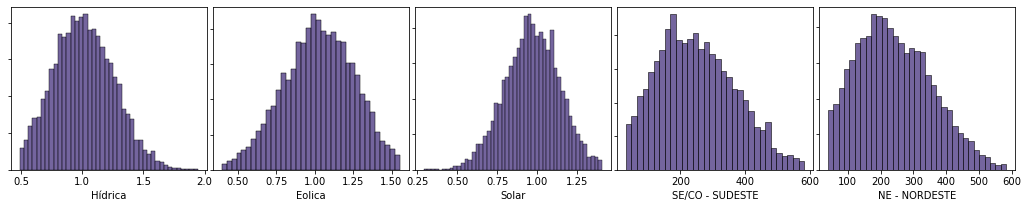

In [191]:
data = pd.DataFrame(dist_norm.T, columns=df_exposição2.columns)
f, axes = plt.subplots(1,5, figsize = (18,3))
f.subplots_adjust(wspace=0.03)

n=0
for serie in data.columns:
    sns.histplot(data[serie],color=sns.color_palette("viridis")[0],ax=axes[n]).set(yticklabels=[],ylabel=None)
    n+=1